# Data Analysis in Geoscience Remote Sensing Projects: Exercises - 2
## Time series analyses: Time series decomposition and change point analyses 
Hendrik Andersen, contact: hendrik.andersen@kit.edu

We will first take a brief look into time series decomposition and then dive into change-point analyses. To work on the time series decomposition, the package statsmodels needs to be installed in your virtual environment. You can install it with this line of code in anaconda:

conda install -c conda-forge statsmodels

## Time series decomposition

<Axes: xlabel='Time', ylabel='Monthly average CO$_2$ at Mauna Loa [ppm]'>

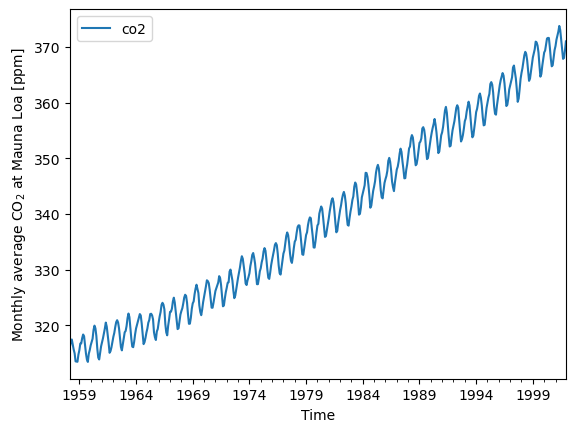

In [1]:
# we are looking into decomposing the classic co2 time series of Mauna Loa, one of the iconic data sets of climate science. 
from sklearn.datasets import fetch_openml
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress

data = fetch_openml(data_id=41187, as_frame=True)
df = data.frame # convert as pandas data frame
df.index = pd.to_datetime(df[['year','month', 'day']]) # use the columns with temporal information to create time stamps and use them as index
df = df.drop(['year','month','day','weight','flag','station'], axis=1) # drop the columns that are not needed
df_resampled = df.resample('m').mean() # resample the data set to monthly means
df_resampled['co2'] = df_resampled['co2'].interpolate() # interpolate the missing values

df_resampled.plot(xlabel='Time', ylabel='Monthly average CO$_2$ at Mauna Loa [ppm]')

In [2]:
import numpy as np
a = np.array([0,1,2,3,4,5,6])
b = np.array([1,2,10])

np.convolve(a,b)

array([ 0,  1,  4, 17, 30, 43, 56, 62, 60])

In [4]:
# the package statsmodels has a nice function to directly decompose time series. 
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomp = seasonal_decompose(x=df_resampled, model='additive', period = 12) # we set the cyclic period of the seasonal cycle by hand
trend_estimate = ts_decomp.trend
seasonal_estimate = ts_decomp.seasonal
residual_estimate = ts_decomp.resid

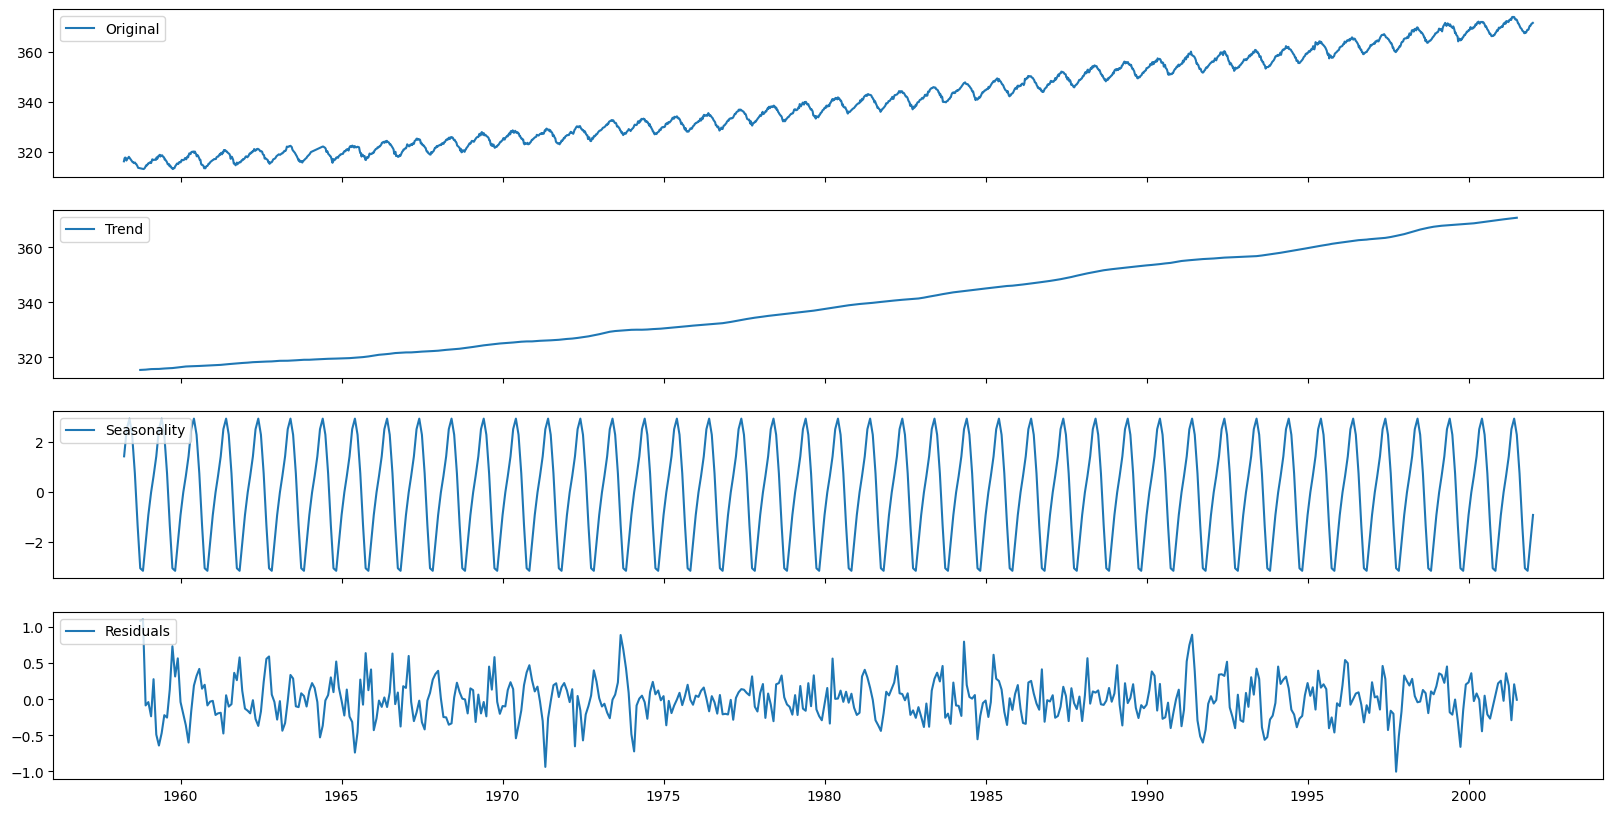

In [6]:
# Plotting the time series and its individual components together
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

ax[0].plot(df, label='Original') 
ax[0].legend(loc='upper left');

ax[1].plot(trend_estimate, label='Trend')
ax[1].legend(loc='upper left');

ax[2].plot(seasonal_estimate, label='Seasonality')
ax[2].legend(loc='upper left');

ax[3].plot(residual_estimate, label='Residuals')
ax[3].legend(loc='upper left');

With the decomposed data, we can directly see:
1. The underlying trend: due to the human emissions, mainly due to the burning of fossil fuels
2. The seasonal cycle: seasonal cycle of vegetation uptake of CO2
3. The residual: this is related to other processes not captured by the trend and seasonal cycle (e.g. weather influences)

## Change-point analyses

Change-point analyses are very problem-specific. In this script, we will look into moving-window approaches similar to the ones discussed in the lecture.

In [13]:
# first, let's create an artificial time series of one year
n = 365
date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(n-1), freq='D')

np.random.seed(seed=1)
data = np.random.randn(n) # x and y are normally distributed random numbers

df = pd.DataFrame({'time': days, 'data': data})

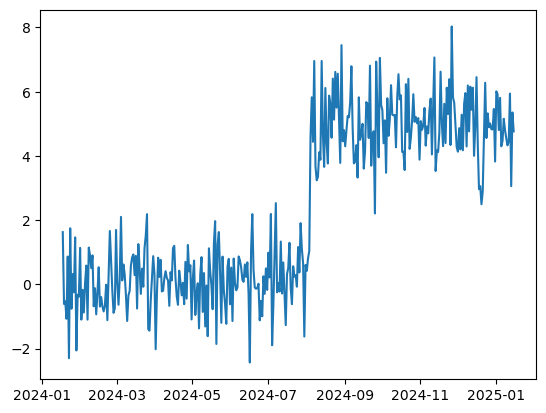

In [14]:
df['data'][200:] += 5 # 5 is added to all values after the 200th data point 

plt.plot(df['time'],df['data'])
plt.show()

In [9]:
def moving_window(data, statistic = 'mean', window_size = 10):
    """Returns a list of a statistic from a moving window
    
    Keyword arguments:
    statistic -- string, can be 'mean', 'std', 'min', 'max'
    window_size -- integer, self explanatory 
    """
    results = []
    for i in range(data.size-window_size):
        if statistic == 'mean':
            results.append(np.mean(data[i:i+window_size]))
        elif statistic == 'std':
            results.append(np.std(data[i:i+window_size]))
        elif statistic == 'max':
            results.append(np.max(data[i:i+window_size]))
        elif statistic == 'min':
            results.append(np.min(data[i:i+window_size]))
        else:
            print('statistic does not exist')
    return results

In [ ]:
moving_window(df['data'],statistic = 'mean', window_size = 10)

__Task 1__

1. Try to understand the function moving_window. What does it do?
2. Experiment with the function and plot different statistics for different window sizes. Which statistic is particularly useful to detect the rapid change in the mean value of the artificial data set? 
3. Usually, much nicer (and faster) implementations of simple functions such as "moving_window" exist. Find a pandas solution that works out of the box as a one-liner. 
4. Find a solution to use a moving window approach to find the correct change point (should be around the 200th data point). You may look at the lecture slides again to help you remind the solution we discussed in the lecture.
5. Write a cell of code in which the change point is detected using the pandas implementation. Plot the time series, and add the detected change point as a red vertical line. Does the change point identify the correct time, and if not - why not? Is there a solution to the problem?

In [16]:
def moving_window(data, statistic = 'mean', window_size = 10):
    """Returns a list of a statistic from a moving window
    
    Keyword arguments:
    statistic -- string, can be 'mean', 'std', 'min', 'max'
    window_size -- integer, self explanatory 
    """
    results = []
    for i in range(data.size-window_size//2):
        if statistic == 'mean':
            results.append(np.mean(data[i:i+window_size]))
        elif statistic == 'std':
            results.append(np.std(data[i:i+window_size]))
        elif statistic == 'max':
            results.append(np.max(data[i:i+window_size]))
        elif statistic == 'min':
            results.append(np.min(data[i:i+window_size]))
        else:
            print('statistic does not exist')
    return results

Let's create a second artificial time series with a different type of change.

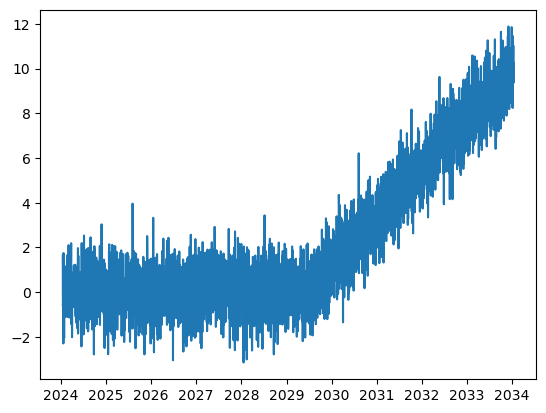

In [10]:
n = 3650
date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(n-1), freq='D')

np.random.seed(seed=1)
data = np.random.randn(n) 

df_trend = pd.DataFrame({'time': days, 'data': data})
df_trend['data'][2000:] += np.linspace(0.1,10,1650) # add a linear trend starting on the 2000th data point 

plt.plot(df_trend['time'],df_trend['data'])

We can clearly see that a trend is introduced around 2028 in this example. To objectively detect the time of the change of the trend from the data itself, let us look at the change in trends in a moving window. First, let's include the trend as a statistic in our moving window function.  

In [11]:
def moving_window(data, statistic = 'mean', window_size = 10):
    from numpy import array
    from scipy.stats import linregress
    """Returns a list of a statistic from a moving window
    
    Keyword arguments:
    statistic -- string, can be 'mean', 'std', 'min', 'max','trend'
    window_size -- integer, self explanatory 
    """
    results = []
    for i in range(data.size-window_size):
        if statistic == 'mean':
            results.append(np.mean(data[i:i+window_size]))
        elif statistic == 'std':
            results.append(np.std(data[i:i+window_size]))
        elif statistic == 'max':
            results.append(np.max(data[i:i+window_size]))
        elif statistic == 'min':
            results.append(np.min(data[i:i+window_size]))
        elif statistic == 'trend':
            try:
                results.append(linregress(np.arange(window_size),data[i:i+window_size]).slope)
            except:
                results.append(np.nan)
        else:
            print('statistic does not exist')
    return array(results)

__Task 2__

6. Now the function "moving_window" includes the "trend" statistic, which is the slope of the linear regression line in a moving window. Experiment with this function to find a way to use this for the change point detection.
7. Detect the change point and create a plot as in Task 1. 